In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import braycurtis
import plotly_express as px
from pyvis.network import Network
import imports

In [2]:
data_d = pd.read_csv(r"C:\Users\tomer\Desktop\BSc\year3\sem B\workshop_microbiome\train_data.csv", index_col="sample")
meta_d = pd.read_csv(r"C:\Users\tomer\Desktop\BSc\year3\sem B\workshop_microbiome\train_metadata.csv",  index_col="sample")

## graph 1

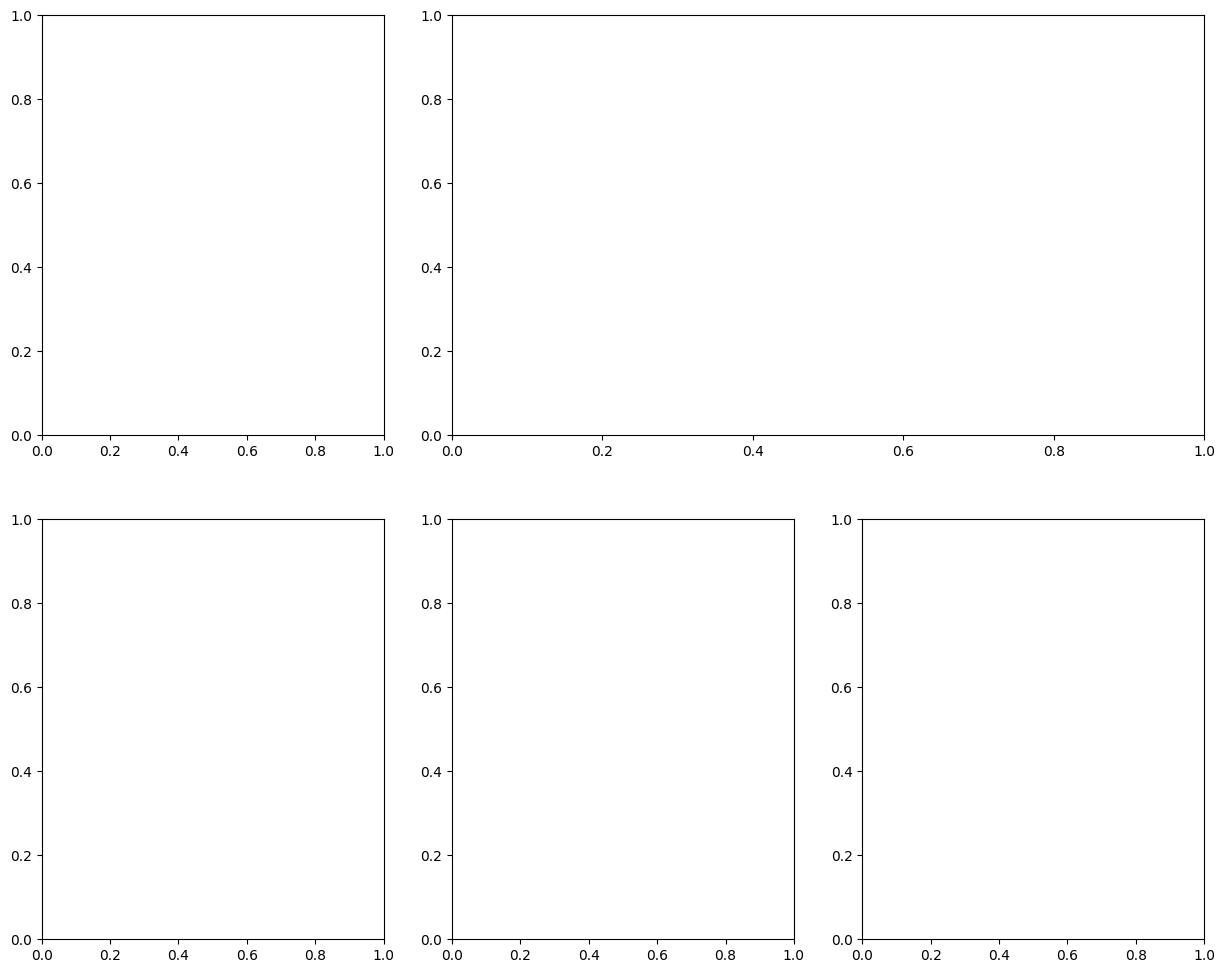

In [3]:
fig,axes = plt.subplot_mosaic([['a', 'b' ,'b'],
                               ['c', 'd', 'e']])
fig.set_size_inches(15, 12)

In [4]:
# sample perbaboon histogram
data_df = data_d.copy()
metadata_df =meta_d.copy()

baboons = metadata_df.groupby("baboon_id").count()["collection_date"]
sns.histplot(baboons, binwidth=10, binrange=(40, 130), ax=axes['a'])
axes['a'].set_xlabel("Number of Samples")
axes['a'].set_ylabel("Number of Baboons")
axes['a'].set_title("Number of Samples per Baboon - Train Data")
axes['a'].text(-0.1, 1.05, 'a', transform=axes['a'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')


Text(-0.1, 1.05, 'a')

In [5]:
# time difference histogram
data_df = data_d.copy()
metadata_df =meta_d.copy()
metadata_df["collection_date"] = (pd.to_datetime(metadata_df['collection_date']) - pd.Timestamp('1970-01-01')).dt.days
metadata_df.sort_values(by=["baboon_id", "collection_date"], inplace=True)
ds = []
for baboon in metadata_df["baboon_id"].unique():
    curr = metadata_df[metadata_df["baboon_id"] == baboon]["collection_date"].values
   
    for i in range(len(curr)-1):
        ds.append(curr[i+1]-curr[i])
        
ds = np.array(ds)


In [6]:
sns.histplot(ds, ax=axes['b'])
for i in range(365//2, max(ds), 365//2):
    axes['b'].vlines(x=i, ymin=0, ymax=1000, color="black")


axes['b'].set_xlabel("Time Difference (Days)")
axes['b'].set_yscale("log")
axes['b'].set_title("Time Difference Between Consecutive Samples")
axes['b'].text(0, 1.05, 'b', transform=axes['b'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')


Text(0, 1.05, 'b')

In [7]:
# ### Month of collection piechart
# data_df = data_d.copy()
# metadata_df =meta_d.copy()
# month_cnt = metadata_df.groupby("month").count().values[:,0]
# palette_color = sns.color_palette("Spectral", 12)

# axes['c'].pie(month_cnt/ np.sum(month_cnt), labels=range(1,13), autopct='%.0f%%', colors=palette_color)
# axes['c'].text(0, 1.05, 'c', transform=axes['c'].transAxes,
#                fontsize=14, fontweight='bold', va='top', ha='right')
# axes['c'].set_title("Month of Collection Distribution")
### using previous sample histogram
data_df = data_d.copy()
metadata_df =meta_d.copy()

metadata_df["collection_date"] = (pd.to_datetime(metadata_df['collection_date']) - pd.Timestamp('1970-01-01')).dt.days
microbiom_with_sample_data = data_df.join(metadata_df[["baboon_id", "collection_date"]], how="inner")
microbiom_with_sample_data = microbiom_with_sample_data.sort_values(["baboon_id", "collection_date"])

bc_scores = []
for baboon in metadata_df["baboon_id"].unique():
    baboon_samples = microbiom_with_sample_data[microbiom_with_sample_data["baboon_id"]==baboon].index
    for i in range(1, len(baboon_samples)):
        bc_scores.append(braycurtis(data_df.loc[baboon_samples[i-1]], data_df.loc[baboon_samples[i]].values))
bc_scores = np.array(bc_scores)

sns.kdeplot(bc_scores, ax=axes['c'])
axes['c'].set_xlabel("Bray Curtis Distance")
axes['c'].set_ylabel("Density")
axes['c'].set_title("Bray Curtis KDE", fontsize=12)
axes['c'].vlines(x = bc_scores.mean(), ymin=0, ymax=4, color="red",label=f"mean ({np.around(np.mean(bc_scores),3)})")
axes['c'].vlines(x = np.median(bc_scores) , ymin=0, ymax=4, color="green", label=f"median ({np.around(np.quantile(bc_scores, 0.5),3)})")


lower_bound = np.quantile(bc_scores, 0.025)
upper_bound = np.quantile(bc_scores, 0.975)

axes['c'].vlines(x = lower_bound, ymin=0, ymax=4, color="blue", label="95% CI")
axes['c'].vlines(x = upper_bound, ymin=0, ymax=4, color="blue")
axes['c'].text(-0.05, 1.05, 'c', transform=axes['c'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')
axes['c'].legend(loc='upper right')

In [8]:
### Same day histogram
data_df = data_d.copy()
metadata_df =meta_d.copy()
indexes_list = []
visited = set()

for index, row in metadata_df.iterrows():
    if not (index in visited):
        collection_date = row['collection_date']
        baboon_id = row['baboon_id']
        matching_indexes = metadata_df[(metadata_df['collection_date'] == collection_date) & (metadata_df['baboon_id'] == baboon_id)].index.tolist()
        visited.update(matching_indexes)

    indexes_list.append(matching_indexes)
indexes_list = [list(l) for l in dict.fromkeys([tuple(sorted(indexes)) for indexes in indexes_list])]
indexes_list = [index for index in indexes_list if len(index) > 1]

bray_curtis_distances = []

for indexes in indexes_list:
    for row1 in data_df.loc[indexes].iterrows():
        for row2 in data_df.loc[indexes].iterrows():
            if row1[0] != row2[0]:
                distance = braycurtis(row1[1], row2[1])
                bray_curtis_distances.append(distance)

bray_curtis_distances = np.array(bray_curtis_distances)
sns.kdeplot(bray_curtis_distances, ax=axes['d'])
axes['d'].set_xlabel("Bray Curtis Distance")
axes['d'].set_ylabel("Density")

axes['d'].vlines(x = bray_curtis_distances.mean(), ymin=0, ymax=4.5, color="red", label=f"mean ({np.around(np.mean(bray_curtis_distances),3)})")
axes['d'].vlines(x = np.median(bray_curtis_distances), ymin=0, ymax=4.5, color="green", label=f"median ({np.around(np.quantile(bray_curtis_distances, 0.5),3)})")



lower_bound = np.quantile(bray_curtis_distances, 0.025)
upper_bound = np.quantile(bray_curtis_distances, 0.975)

axes['d'].vlines(x = lower_bound, ymin=0, ymax=4.5, color="blue", label="95% CI")
axes['d'].vlines(x = upper_bound, ymin=0, ymax=4.5, color="blue")


axes['d'].text(-0.05, 1.05, 'd', transform=axes['d'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')
axes['d'].set_title("Bray- Curtis KDE", fontsize=12)
axes['d'].legend(loc='upper right')


In [9]:
### mean of previous histogram
data_df = data_d.copy()
metadata_df =meta_d.copy()

metadata_df["collection_date"] = (pd.to_datetime(metadata_df['collection_date']) - pd.Timestamp('1970-01-01')).dt.days
microbiom_with_sample_data = data_df.join(metadata_df[["baboon_id", "collection_date"]], how="inner")
microbiom_with_sample_data = microbiom_with_sample_data.sort_values(["baboon_id", "collection_date"])



bc_scores = []
for baboon in metadata_df["baboon_id"].unique():
    baboon_samples = microbiom_with_sample_data[microbiom_with_sample_data["baboon_id"]==baboon].index
    for i in range(1, len(baboon_samples)):
        mean_previous = imports.to_composition(imports.transformation(data_df.loc[baboon_samples[0:i]]).mean().values)
        bc_scores.append(braycurtis(mean_previous, data_df.loc[baboon_samples[i]].values))
bc_scores = np.array(bc_scores)

sns.kdeplot(bc_scores, ax=axes['e'])
axes['e'].set_xlabel("Bray Curtis Distance")
axes['e'].set_ylabel("Density")
axes['e'].set_title("Bray Curtis KDE", fontsize=12)
axes['e'].vlines(x = bc_scores.mean(), ymin=0, ymax=4, color="red",label=f"mean ({np.around(np.mean(bc_scores),3)})")
axes['e'].vlines(x = np.median(bc_scores) , ymin=0, ymax=4, color="green", label=f"median ({np.around(np.quantile(bc_scores, 0.5),3)})")


lower_bound = np.quantile(bc_scores, 0.025)
upper_bound = np.quantile(bc_scores, 0.975)

axes['e'].vlines(x = lower_bound, ymin=0, ymax=4, color="blue", label="95% CI")
axes['e'].vlines(x = upper_bound, ymin=0, ymax=4, color="blue")
axes['e'].text(-0.05, 1.05, 'e', transform=axes['e'].transAxes,
               fontsize=14, fontweight='bold', va='top', ha='right')
axes['e'].legend(loc='upper right')

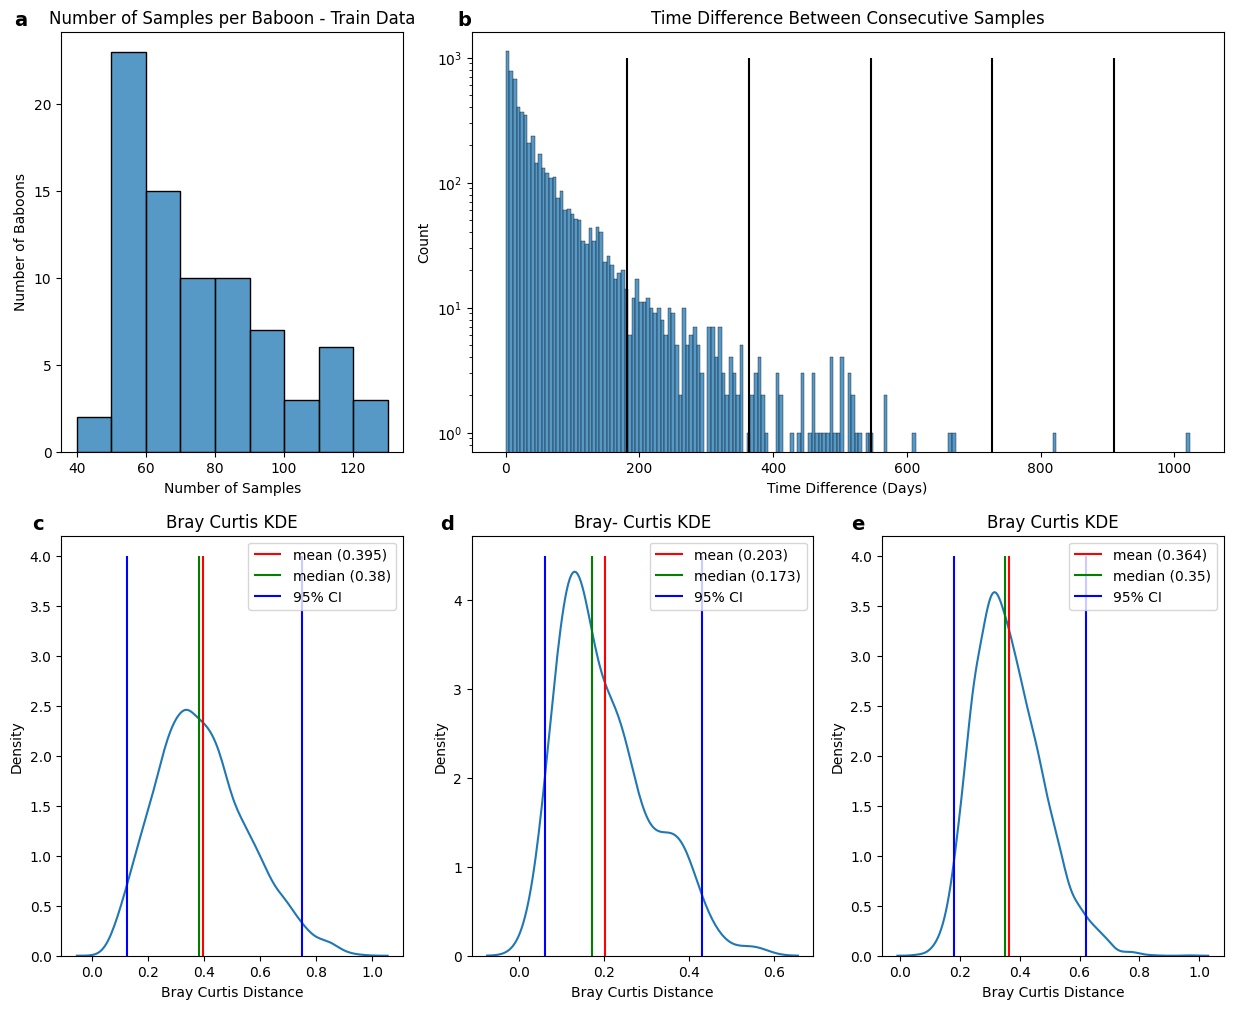

In [10]:
fig